# Part A: Basic Prescriptive Analytics

In [151]:
# !pip install pyspark shapely pandas geopandas matplotlib seaborn numpy geopy

In [152]:
# imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import TimestampType
from shapely.geometry import Point
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

**Data Ingestion**

In [153]:
# display(dbutils.fs.ls("dbfs:/FileStore/tables/"))

In [154]:
# #specific to colab
# try:
#   df = pd.read_csv("realtor-data.zip.csv")
# except:
# ! kaggle datasets download "elemento/nyc-yellow-taxi-trip-data" --force
# ! unzip nyc-yellow-taxi-trip-data.zip
# df = pd.read_csv("realtor-data.zip.csv")

In [155]:
# a) initialize spark session
spark = SparkSession.builder.appName("NYC Taxi Data").getOrCreate()

# b) load dataset
df1 = spark.read.format("csv").option("header", "true").load("yellow_tripdata_2015-01.csv").limit(25000)
df2 = spark.read.format("csv").option("header", "true").load("yellow_tripdata_2016-01.csv").limit(25000)
df3 = spark.read.format("csv").option("header", "true").load("yellow_tripdata_2016-02.csv").limit(25000)
df4 = spark.read.format("csv").option("header", "true").load("yellow_tripdata_2016-03.csv").limit(25000)

# df2 = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/tables/yellow_tripdata_2016_01.csv")

df = df1.union(df2)
df = df.union(df3)
df = df.union(df4)

In [156]:
df.count()

100000

**Initial Data Exploration**

In [157]:
# # a) schema
# df.count()
# df.show(5)
# df.columns
# df.printSchema()
# df.describe().show()

# # b) basic stats
# df.select("trip_distance", "passenger_count", "fare_amount").describe().show()

**Data Cleaning**

In [158]:
# a) handle missing values
df = df.dropna(subset=["fare_amount", "trip_distance", "passenger_count"])

# b) filter out rows w/ invalid data
df = df.filter((col("fare_amount") >= 0) & (col("trip_distance") > 0))

# c) convert `pickup_datetime` and `dropoff_datetime` to timestamp
df = df.withColumn("tpep_pickup_datetime", col("tpep_pickup_datetime").cast(TimestampType())) \
       .withColumn("tpep_dropoff_datetime", col("tpep_dropoff_datetime").cast(TimestampType()))

# d) create new columns (trip duration in min, trip speed in mph)
## trip duration in min
df = df.withColumn("trip_duration_exact",
                   (unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime")) / 60)

df = df.withColumn("trip_duration_mins", df["trip_duration_exact"].cast("int"))


## trip speed in mph
df = df.withColumn("trip_speed_mph",
                   col("trip_distance") / (col("trip_duration_mins") / 60))

## display
df.select("tpep_pickup_datetime", "tpep_dropoff_datetime", "trip_distance", "trip_duration_exact", "trip_duration_mins", "trip_speed_mph").show()

+--------------------+---------------------+-------------+-------------------+------------------+------------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|trip_distance|trip_duration_exact|trip_duration_mins|    trip_speed_mph|
+--------------------+---------------------+-------------+-------------------+------------------+------------------+
| 2015-01-15 19:05:39|  2015-01-15 19:23:42|         1.59|              18.05|                18| 5.300000000000001|
| 2015-01-10 20:33:38|  2015-01-10 20:53:28|         3.30| 19.833333333333332|                19|10.421052631578947|
| 2015-01-10 20:33:38|  2015-01-10 20:43:41|         1.80|              10.05|                10|              10.8|
| 2015-01-10 20:33:39|  2015-01-10 20:52:58|         3.00| 19.316666666666666|                19| 9.473684210526317|
| 2015-01-10 20:33:39|  2015-01-10 20:53:52|         9.00| 20.216666666666665|                20|              27.0|
| 2015-01-10 20:33:39|  2015-01-10 20:58:31|         2.20| 24.86

**Exploratory Data Analysis**

In [159]:
# a) calculate avg fare and avg trip distance grouped by num of passengers
df.groupBy("passenger_count") \
  .agg(avg("fare_amount").alias("avg_fare"), avg("trip_distance").alias("avg_trip_distance")) \
  .orderBy("passenger_count") \
  .show()

# b) busiest times of day for taxi pickup
df.groupBy(hour("tpep_pickup_datetime").alias("hour")) \
  .agg(count("*").alias("pickup_count")) \
  .orderBy("pickup_count", ascending=False) \
  .show()


+---------------+------------------+------------------+
|passenger_count|          avg_fare| avg_trip_distance|
+---------------+------------------+------------------+
|              0| 9.090909090909092|1.7090909090909094|
|              1| 14.04878511195115| 3.515097799747983|
|              2|14.383493387246231| 3.626421531463237|
|              3|14.167116598079561|3.5640850480109716|
|              4|14.407798165137615| 3.624094036697248|
|              5|14.058589967073408|3.5048285880302186|
|              6|13.986577181208053| 3.482803538743135|
+---------------+------------------+------------------+

+----+------------+
|hour|pickup_count|
+----+------------+
|  21|       16969|
|   8|        9311|
|   7|        8197|
|   1|        7370|
|   2|        5750|
|   3|        4623|
|  20|        4542|
|   9|        3944|
|   0|        3132|
|  19|        1499|
|  18|        1214|
|  17|        1080|
|  16|        1059|
|  23|        1031|
|  14|        1023|
|  15|         939|
|  

In [160]:
# c) neighbourhoods w/ highest average fare amount

# # k-means method
# df_casted = df.withColumn("pickup_longitude", col("pickup_longitude").cast("double")) \
#               .withColumn("pickup_latitude", col("pickup_latitude").cast("double"))

# assembler = VectorAssembler(inputCols=["pickup_longitude", "pickup_latitude"], outputCol="features")
# df_kmeans = assembler.transform(df_casted)

# kmeans = KMeans(k=10, seed=1)
# model = kmeans.fit(df_kmeans)
# df_clusters = model.transform(df_kmeans).withColumnRenamed("prediction", "cluster")

# cluster_avg_fare = df_clusters.groupBy("cluster").agg(avg("fare_amount").alias("avg_fare")).orderBy("avg_fare", ascending=False)
# cluster_avg_fare.show()

from geopy.geocoders import Nominatim
import time

geolocator = Nominatim(user_agent="databricks_geocoder")

def get_postal_code(lat, lon):
    try:
        location = geolocator.reverse(f"{lat}, {lon}", language="en", timeout=10)
        time.sleep(1)
        if location and "postcode" in location.raw["address"]:
            return location.raw["address"]["postcode"]
        else:
            return None
    except Exception as e:
        return None

## only works with ~10 otherwise crashes. IF CRASHES with ConnectionRefusedError or similar, restart VScode
df_sample = df.limit(10)
df_gpd = df_sample.toPandas()
df_gpd["PostalCode"] = df_gpd.apply(lambda row: get_postal_code(row["pickup_latitude"], row["pickup_longitude"]), axis=1)

df_gpd_spark = spark.createDataFrame(df_gpd)
df_gpd_spark.show(5)

+--------+--------------------+---------------------+---------------+-------------+-------------------+------------------+----------+------------------+-------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+-------------------+------------------+------------------+----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|   pickup_longitude|   pickup_latitude|RateCodeID|store_and_fwd_flag|  dropoff_longitude|  dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|trip_duration_exact|trip_duration_mins|    trip_speed_mph|PostalCode|
+--------+--------------------+---------------------+---------------+-------------+-------------------+------------------+----------+------------------+-------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------

**Visualizing the Data**

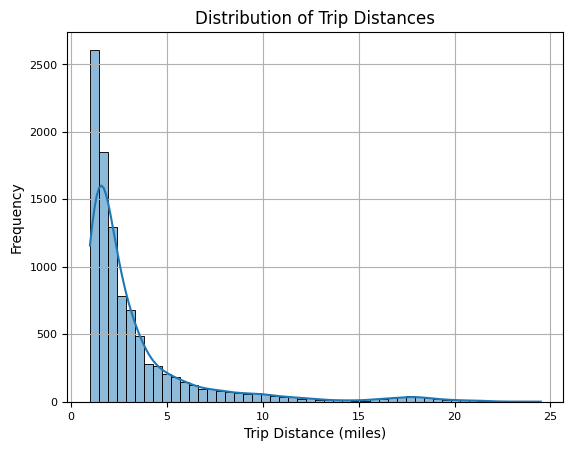

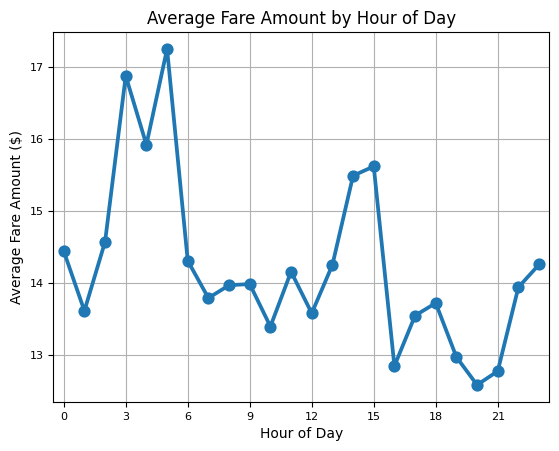

In [161]:
p_df = df.select("trip_distance", "fare_amount", "tpep_pickup_datetime").limit(10000).toPandas()

# a) distribution plot of trip distances
p_df['trip_distance'] = pd.to_numeric(p_df['trip_distance'], errors='coerce')
p_df = p_df.dropna(subset=['trip_distance'])
filtered_df = p_df[p_df['trip_distance'] <= 25]

ax = sns.histplot(data=filtered_df, x='trip_distance', bins=50, kde=True)

plt.title('Distribution of Trip Distances', fontsize=12)
plt.xlabel('Trip Distance (miles)', fontsize=10)
plt.ylabel('Frequency', fontsize=10)

plt.yticks(fontsize=8)
plt.xticks(fontsize=8)

plt.grid(True)
plt.show()

# b) average fares by hour of day
p_df['tpep_pickup_datetime'] = pd.to_datetime(p_df['tpep_pickup_datetime'])
p_df['fare_amount'] = pd.to_numeric(p_df['fare_amount'], errors='coerce')
p_df['hour'] = p_df['tpep_pickup_datetime'].dt.hour
avg_fph = p_df.groupby('hour')['fare_amount'].mean().reset_index()
avg_fph.columns = ['Hour of Day', 'Average Fare Amount']

sns.pointplot(data=avg_fph, x='Hour of Day', y='Average Fare Amount')

plt.title('Average Fare Amount by Hour of Day', fontsize=12)
plt.xlabel('Hour of Day', fontsize=10)
plt.ylabel('Average Fare Amount ($)', fontsize=10)

plt.xticks(ticks=[0, 3, 6, 9, 12, 15, 18, 21], fontsize=8)
plt.yticks(fontsize=8)

plt.grid(True)
plt.show()

#Part B: Advanced Prescriptive Analytics:
####Feature Engineering – Compute the following “extraction of new useful features”

####1.
#####This question was already done in part A
#####Results are visible below

In [162]:
df.select("trip_duration_mins").show()

+------------------+
|trip_duration_mins|
+------------------+
|                18|
|                19|
|                10|
|                19|
|                20|
|                24|
|                37|
|                 9|
|                29|
|                 5|
|                26|
|                15|
|                22|
|                14|
|                14|
|                25|
|                 6|
|                16|
|                 8|
|                10|
+------------------+
only showing top 20 rows



####2.

In [163]:
df = df.withColumn("pickup_day", dayofmonth("tpep_pickup_datetime").cast("int"))
df = df.withColumn("pickup_hour", hour("tpep_pickup_datetime").cast("int"))

In [164]:
df.columns

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'pickup_longitude',
 'pickup_latitude',
 'RateCodeID',
 'store_and_fwd_flag',
 'dropoff_longitude',
 'dropoff_latitude',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'trip_duration_exact',
 'trip_duration_mins',
 'trip_speed_mph',
 'pickup_day',
 'pickup_hour']

####3.

In [165]:
#We'll create a new column to extract the year of the trip, from the pickup date
#Even if someone calls a taxi during new years countdown (hypothetically), it should still count as a taxi trip from the year they entered the taxi in

In [166]:
df = df.withColumn("pickup_year", year("tpep_pickup_datetime"))

In [167]:
duration_2015_value = df.filter(df["pickup_year"] == 2015).agg(avg("trip_duration_mins")).first()[0]
duration_2016_value = df.filter(df["pickup_year"] == 2016).agg(avg("trip_duration_mins")).first()[0]

In [168]:
print(f"The fare increased by ${duration_2016_value-duration_2015_value} between the years 2015 and 2016 (the only 2 years present in this dataset)")

The fare increased by $2.468667892944369 between the years 2015 and 2016 (the only 2 years present in this dataset)


In [169]:
average_year_duration_df = pd.DataFrame({"Year": [2015, 2016],
                                "Average Trip Duration": [duration_2015_value, duration_2016_value]
                                })

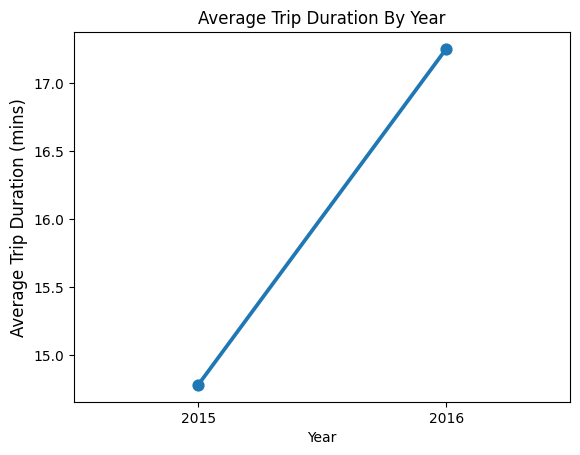

In [170]:
sns.pointplot(data=average_year_duration_df, x="Year", y="Average Trip Duration")

plt.title('Average Trip Duration By Year', fontsize=12)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Average Trip Duration (mins)', fontsize=12)

plt.show()

####4.

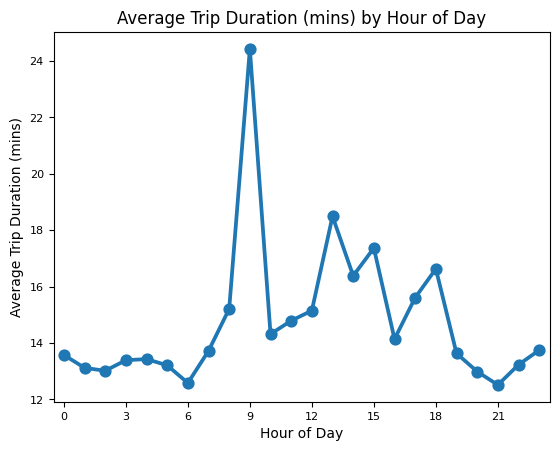

In [171]:
p_df = df.select("trip_duration_mins", "tpep_pickup_datetime").limit(10000).toPandas()


p_df['tpep_pickup_datetime'] = pd.to_datetime(p_df['tpep_pickup_datetime'])
p_df['hour'] = p_df['tpep_pickup_datetime'].dt.hour
avg_dph = p_df.groupby('hour')['trip_duration_mins'].mean().reset_index()
avg_dph.columns = ['Hour of Day', 'Average Trip Duration']

sns.pointplot(data=avg_dph, x='Hour of Day', y='Average Trip Duration')

plt.title('Average Trip Duration (mins) by Hour of Day', fontsize=12)
plt.xlabel('Hour of Day', fontsize=10)
plt.ylabel('Average Trip Duration (mins)', fontsize=10)

plt.xticks(ticks=[0, 3, 6, 9, 12, 15, 18, 21], fontsize=8)
plt.yticks(fontsize=8)

# plt.grid(True)
plt.show()

You can see that between 9 and 10am is definitely rush hour for NYC.
There is another spike at 1pm-2pm where many people may go out for lunch/go back home to eat
And another spike at 6pm-7pm where many people are heading home from work

####5.

In [172]:
df = df.withColumn('pickup_longitude', df["pickup_longitude"].cast("double"))
df = df.withColumn('pickup_latitude', df["pickup_latitude"].cast("double"))

In [173]:
#accuracy to 11.1m
#(https://support.garmin.com/en-CA/?faq=hRMBoCTy5a7HqVkxukhHd8)
df = df.withColumn('pickup_longitude', round(df["pickup_longitude"], 4))
df = df.withColumn('pickup_latitude', round(df["pickup_latitude"], 4))

In [174]:
df = df.withColumn("lat_and_long", concat(col("pickup_latitude"), lit(", "), col("pickup_longitude")))

In [175]:
df.select("lat_and_long").show()

+-----------------+
|     lat_and_long|
+-----------------+
|40.7501, -73.9939|
|40.7242, -74.0016|
|40.8028, -73.9633|
|40.7624, -73.9712|
| 40.774, -73.8744|
| 40.726, -73.9833|
| 40.6444, -73.783|
|40.7514, -73.9938|
|40.7604, -73.9739|
|40.7318, -74.0067|
|40.7398, -73.9764|
|40.7542, -73.9687|
|40.7696, -73.8631|
|40.7794, -73.9455|
| 40.774, -73.8745|
|40.7519, -73.9766|
|40.7179, -74.0028|
|40.7364, -73.9975|
| 40.824, -73.9523|
|40.7501, -73.9911|
+-----------------+
only showing top 20 rows



In [176]:
lat_and_long_df = df.groupBy("lat_and_long").count()
top_lat_and_long = lat_and_long_df.orderBy("count", ascending=False).limit(10).toPandas()

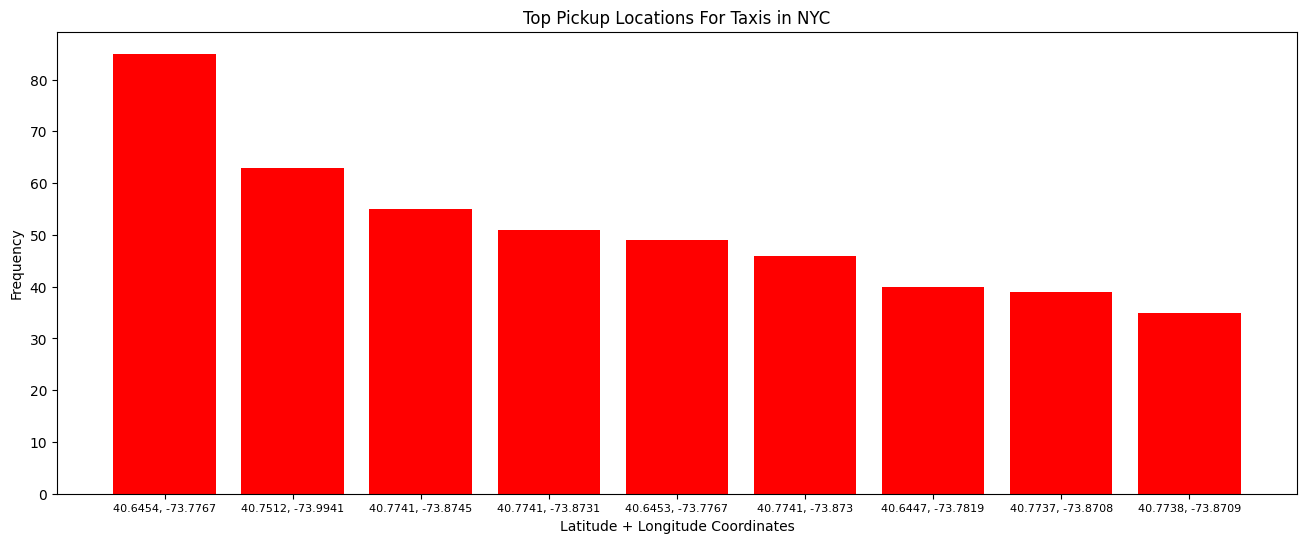

In [177]:
top_lat_and_long["lat_and_long"] = top_lat_and_long["lat_and_long"].astype(str) #From object type to string

plt.figure(figsize=(16, 6))

#We exclude the top value, because the top value is a value of (0, 0), which indicates that it is a placeholder for
#unknown long/lat coordinates
plt.bar(top_lat_and_long["lat_and_long"].tail(9), top_lat_and_long["count"].tail(9), color="red")
plt.title("Top Pickup Locations For Taxis in NYC")
plt.xlabel("Latitude + Longitude Coordinates")
plt.ylabel("Frequency")
plt.xticks(size=8)

plt.show()

Lets do it again for dropoff coordinates

In [178]:
df = df.withColumn('dropoff_longitude', df["dropoff_longitude"].cast("double"))
df = df.withColumn('dropoff_latitude', df["dropoff_latitude"].cast("double"))

df = df.withColumn('dropoff_longitude', round(df["dropoff_longitude"], 4))
df = df.withColumn('dropoff_latitude', round(df["dropoff_latitude"], 4))


In [179]:
df = df.withColumn("lat_and_long_dropoff", concat(col("dropoff_latitude"), lit(", "), col("dropoff_longitude")))

In [180]:
df.select("lat_and_long_dropoff").show()

+--------------------+
|lat_and_long_dropoff|
+--------------------+
|   40.7506, -73.9748|
|   40.7591, -73.9944|
|   40.8244, -73.9518|
|   40.7427, -74.0042|
|    40.7582, -73.987|
|   40.7496, -73.9925|
|   40.7594, -73.9876|
|   40.7572, -73.9674|
|   40.7352, -73.9973|
|   40.7399, -73.9952|
|    40.7579, -73.984|
|   40.7869, -73.9551|
|   40.7858, -73.9527|
|   40.7861, -73.9809|
|   40.7186, -73.9524|
|   40.7146, -73.9989|
|   40.7042, -74.0079|
|   40.7619, -73.9782|
|   40.8111, -73.9533|
|   40.7349, -73.9886|
+--------------------+
only showing top 20 rows



In [181]:
lat_and_long_df_dropoff = df.groupBy("lat_and_long_dropoff").count()
top_lat_and_long_dropoff = lat_and_long_df_dropoff.orderBy("count", ascending=False).limit(10).toPandas()

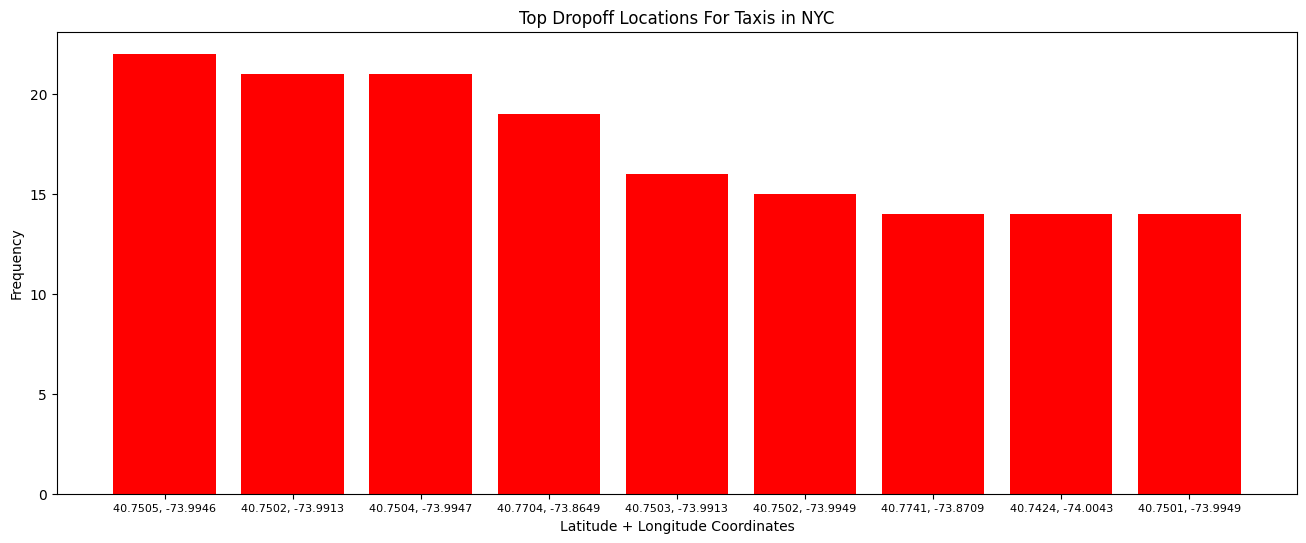

In [182]:
top_lat_and_long_dropoff["lat_and_long_dropoff"] = top_lat_and_long_dropoff["lat_and_long_dropoff"].astype(str) #From object type to string

plt.figure(figsize=(16, 6))

plt.bar(top_lat_and_long_dropoff["lat_and_long_dropoff"].tail(9), top_lat_and_long_dropoff["count"].tail(9), color="red")
plt.title("Top Dropoff Locations For Taxis in NYC")
plt.xlabel("Latitude + Longitude Coordinates")
plt.ylabel("Frequency")
plt.xticks(size=8)

plt.show()

####6.

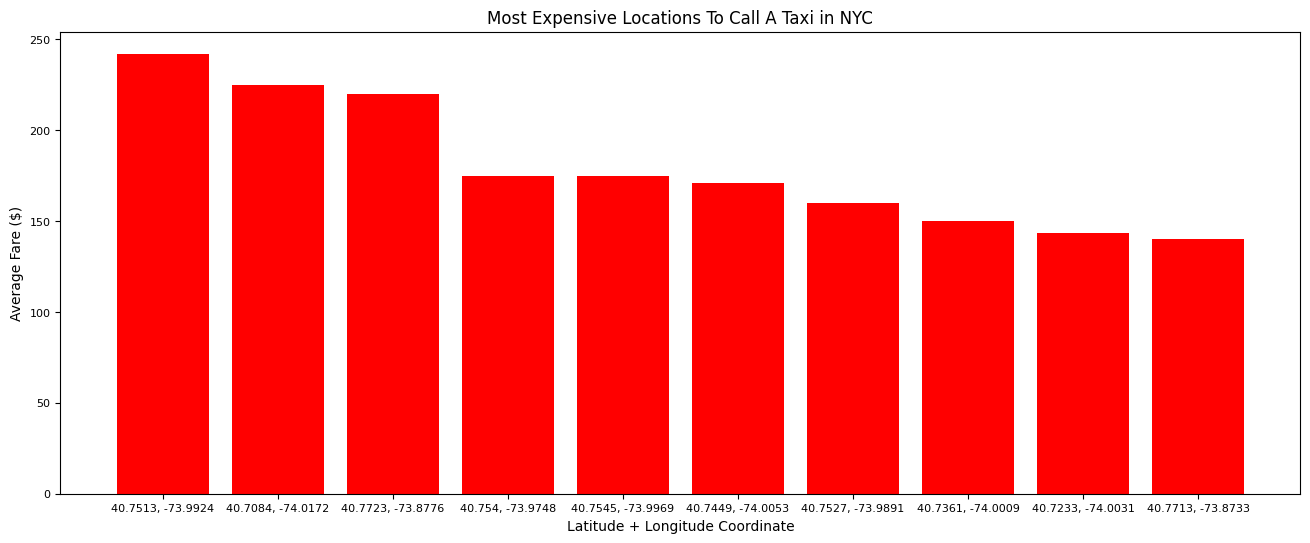

In [184]:
lat_and_long_fare_df = df.groupBy("lat_and_long").agg(mean("fare_amount").alias("avg_fare_amount"))
top_lat_and_long_fare_df = lat_and_long_fare_df.orderBy("avg_fare_amount", ascending=False).limit(10).toPandas()

top_lat_and_long_fare_df["lat_and_long"] = top_lat_and_long_fare_df["lat_and_long"].astype(str)

plt.figure(figsize=(16, 6))

plt.bar(top_lat_and_long_fare_df["lat_and_long"], top_lat_and_long_fare_df["avg_fare_amount"], color="red")
plt.title("Most Expensive Locations To Call A Taxi in NYC")
plt.xlabel("Latitude + Longitude Coordinate")
plt.ylabel("Average Fare ($)")
plt.xticks(size=8)
plt.yticks(size=8)

plt.show()

####7.

In [185]:
df.columns

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'pickup_longitude',
 'pickup_latitude',
 'RateCodeID',
 'store_and_fwd_flag',
 'dropoff_longitude',
 'dropoff_latitude',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'trip_duration_exact',
 'trip_duration_mins',
 'trip_speed_mph',
 'pickup_day',
 'pickup_hour',
 'pickup_year',
 'lat_and_long',
 'lat_and_long_dropoff']

#####Key features include:
'passenger_count',
'duration_in_mins',
'trip_distance',
'fare_amount',
'extra'

Steps
1. Perform a heatmap correlation analysis between them
2. Explore the notable  ones in further detail

In [186]:
p_df = df.toPandas()
p_df[['passenger_count', 'trip_duration_mins', 'trip_distance', 'fare_amount', 'extra']].dtypes


,0
passenger_count,object
trip_duration_mins,int32
trip_distance,object
fare_amount,object
extra,object


In [187]:
p_df[['passenger_count', 'trip_duration_mins', 'trip_distance', 'fare_amount', 'extra']] = p_df[['passenger_count', 'trip_duration_mins', 'trip_distance', 'fare_amount', 'extra']].astype(float).astype(int)

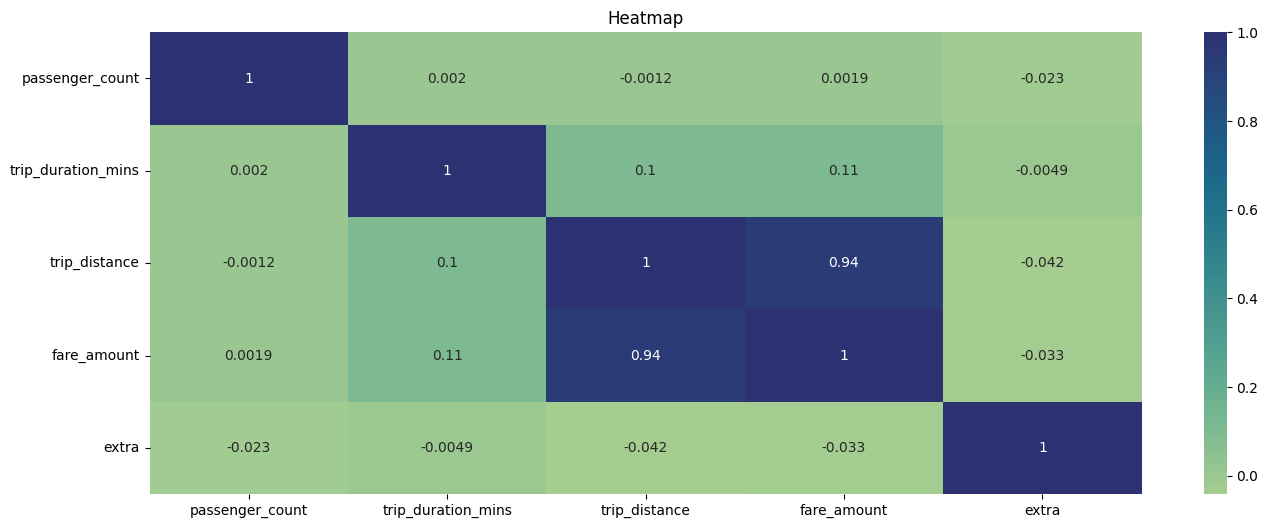

In [188]:
plt.figure(figsize=(16, 6))
sns.heatmap(p_df[['passenger_count', 'trip_duration_mins', 'trip_distance', 'fare_amount', 'extra']].corr(), annot=True, cmap="crest")

plt.title("Heatmap")
plt.show()

As expected, fare_amount and trip_distance have an extremely high correlation. Apart from those, duration, distance, and the fare amount are not nearly as correlated as we might expect.

One possible reason for explaning why distance and duration may have a lower correlation than expected is traffic. In a busy city like NYC, there is a lot of noise or randomness in how long your trip takes.

A reason for why fare amount may have a lower correlation with the two than expected may be due to taxi base fees, as well as different taxi services having different prices, in addition to time of day also playing a role.

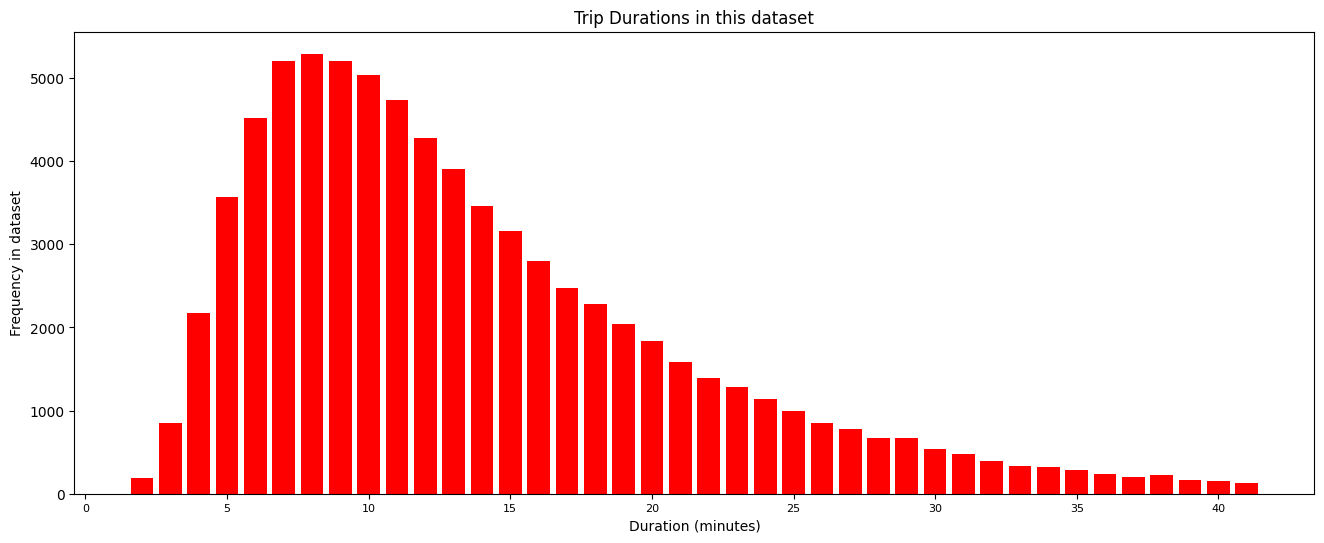

In [189]:
duration_df = p_df["trip_duration_mins"].value_counts(ascending=False).head(40)
plt.figure(figsize=(16, 6))
plt.bar(duration_df.index, duration_df, color="red")
plt.title("Trip Durations in this dataset")
plt.xlabel("Duration (minutes)")
plt.ylabel("Frequency in dataset")
plt.xticks(size=8)

plt.show()

This theory of base fees having a higher impact than expected is further supported by the right-skewed graph above. Most trips are short in our dataset, and thus base fees may play a more important role in fare prices, with distance and direction playing a less important role in this dataset regarding correlation to the fare price.

####8.

In [190]:
df = df.withColumn("pickup_month", month("tpep_pickup_datetime").cast("int"))

#Seasonality code
#This ended up not working well, because the data does not have seasons beyond winter
#It even says this in the Kaggle dataset after I checked it: "Jan 2015 & Jan-mar 2016."
# df = df.withColumn(
#     "pickup_season",
#     when((col("pickup_month") <= 2) | ((col("pickup_month") == 3) & (col("pickup_day") <= 19)), "Winter")
#     .when((col("pickup_month") <= 4) | ((col("pickup_month") == 5) & (col("pickup_day") <= 19)), "Spring")
#     .when((col("pickup_month") <= 8) | ((col("pickup_month") == 9) & (col("pickup_day") <= 21)), "Summer")
#     .otherwise("Fall")
# )

month_df = df.select("pickup_month").toPandas()

In [191]:
month_df_vcs = month_df.value_counts()

In [192]:
month_df_vcs

,count
pickup_month,
1,39019
2,19591
3,18687


In [194]:
month_df_vcs.index = ["January", "February", "March"]

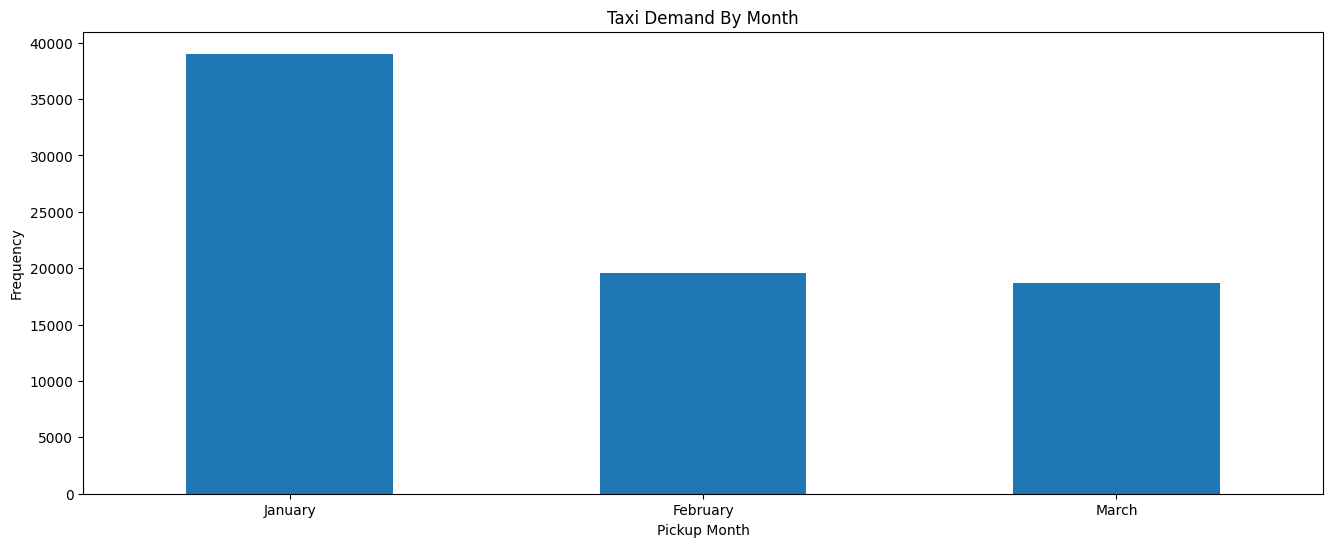

In [197]:
plt.figure(figsize=(16, 6))
month_df_vcs.plot(kind="bar")
plt.xlabel("Pickup Month")
plt.ylabel("Frequency")
plt.title("Taxi Demand By Month")
plt.xticks(rotation=0)
plt.show()